# Introduction to DataFrames
**This is from the excellent Julia tutorial by [Bogumił Kamiński](http://bogumilkaminski.pl/about/)** <br>
Entire tutorial available [here](https://github.com/bkamins/Julia-DataFrames-Tutorial)

Later in this course we will use Julia to manipulate and transform environmental datasets before interrogating with the IBM AutoAI tool. The basic process involves:
- Load data from CSV files
- Manipulate and transform in Julia
- Save to CSV and load to AutoAI dashboard
This notebook illustrates the structure to load and save various dataforms in Julia

In [5]:
using DataFrames

## Load and save DataFrames
We do not cover all features of the packages. Please refer to their documentation to learn them.

Here we'll load CSV.jl to read and write CSV files and Arrow.jl, JLSO.jl, and serialization, which allow us to work with a binary format and JSONTables.jl for JSON interaction. Finally we consider a custom JDF.jl format.

In [6]:
using Arrow
using CSV
using Serialization
using JLSO
using JSONTables
using CodecZlib
using ZipFile
using JDF
using StatsPlots # for charts
using Mmap # for compression

Let's create a simple `DataFrame` for testing purposes,

In [7]:
x = DataFrame(A=[true, false, true], B=[1, 2, missing],
              C=[missing, "b", "c"], D=['a', missing, 'c'])

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

and use `eltypes` to look at the columnwise types.

In [8]:
eltype.(eachcol(x))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

### CSV.jl

Let's use `CSV` to save `x` to disk; make sure `x1.csv` does not conflict with some file in your working directory.

In [9]:
CSV.write("x1.csv", x)

"x1.csv"

Now we can see how it was saved by reading `x.csv`.

In [10]:
print(read("x1.csv", String))

A,B,C,D
true,1,,a
false,2,b,
true,,c,c


We can also load it back.

In [11]:
y = CSV.read("x1.csv", DataFrame)

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  String? 
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

Note that when loading in a `DataFrame` from a `CSV` the column type for column `:D` has changed!

In [12]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

### Serialization, JDF.jl, and JLSO.jl

#### Serialization
Like other programming languages, Julia also provides support for Serialization and De-serialization. The process of conversion of an object into byte streams (IO buffers) for the purpose of storing it into memory, file, or database is termed as Serialization. It is performed to save the object state for later use. The reverse process is termed as De-serialization.

Now we use serialization to save `x`.

There are two ways to perform serialization. The first way is to use the `Serialization.serialize` as below:

Note that in general, this process will not work if the reading and writing are done by different versions of Julia, or an instance of Julia with a different system image.

In [17]:
open("x.bin", "w") do io
    serialize(io, x)
end

Now we load back the saved file to `y` variable. Again `y` is identical to `x`. However, please beware that if you session does not have DataFrames.jl loaded, then it may not recognise the content as DataFrames.jl

In [18]:
y = open(deserialize, "x.bin")

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [19]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

#### JDF.jl

[JDF.jl](https://github.com/xiaodaigh/JDF) is a relatively new package designed to serialize DataFrames. You can save a DataFrame with the `savejdf` function.

In [20]:
JDF.save("x.jdf", x);

To load the saved JDF file, one can use the `loadjdf` function

In [21]:
x_loaded = JDF.load("x.jdf") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

You can see that they are the same

In [22]:
isequal(x_loaded, x)

true

JDF.jl offers the ability to load only certain columns from disk to help with working with large files

In [23]:
# set up a JDFFile which is a on disk representation of `x` backed by JDF.jl
x_ondisk = jdf"x.jdf"

JDFFile{String}("x.jdf")

We can see all the names of `x` without loading it into memory

In [24]:
names(x_ondisk)

4-element Vector{Symbol}:
 :A
 :B
 :C
 :D

The below is an example of how to load only columns `:A` and `:D` 

In [25]:
xd = JDF.load(x_ondisk; cols = ["A", "D"]) |> DataFrame

3×2 DataFrame
 Row │ A      D       
     │ Bool   Char?   
─────┼────────────────
   1 │  true  a
   2 │ false  missing 
   3 │  true  c

##### JDF.jl vs others

For more details about design assumptions and limitations of JDF.jl check out https://github.com/xiaodaigh/JDF.jl.

#### JLSO.jl

Another way to perform serialization is by using the [JLSO.jl](https://github.com/invenia/JLSO.jl) library:

In [26]:
JLSO.save("x.jlso", :data => x)

Now we can laod back the file to `y`

In [27]:
y = JLSO.load("x.jlso")[:data]

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [28]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

### JSONTables.jl

Often you might need to read and write data stored in JSON format. JSONTables.jl provides a way to process them in row-oriented or column-oriented layout. We present both options below.

In [29]:
open(io -> arraytable(io, x), "x1.json", "w")

106

In [30]:
open(io -> objecttable(io, x), "x2.json", "w")

76

In [31]:
print(read("x1.json", String))

[{"A":true,"B":1,"C":null,"D":"a"},{"A":false,"B":2,"C":"b","D":null},{"A":true,"B":null,"C":"c","D":"c"}]

In [32]:
print(read("x2.json", String))

{"A":[true,false,true],"B":[1,2,null],"C":[null,"b","c"],"D":["a",null,"c"]}

In [33]:
y1 = open(jsontable, "x1.json") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  String? 
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [34]:
eltype.(eachcol(y1))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

In [35]:
y2 = open(jsontable, "x2.json") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  String? 
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [36]:
eltype.(eachcol(y2))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

### Arrow.jl

Finally we use Apache Arrow format that allows, in particular, for data interchange with R or Python.

In [37]:
Arrow.write("x.arrow", x)

"x.arrow"

In [38]:
y = Arrow.Table("x.arrow") |> DataFrame

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [39]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

Note that columns of `y` are immutable

In [40]:
y.A[1] = false

LoadError: ReadOnlyMemoryError()

This is because `Arrow.Table` uses memory mapping and thus uses a custom vector types:

In [41]:
y.A

3-element Arrow.BoolVector{Bool}:
 1
 0
 1

In [42]:
y.B

3-element Arrow.Primitive{Union{Missing, Int64}, Vector{Int64}}:
 1
 2
  missing

You can get standard Julia Base vectors by copying a data frame

In [43]:
y2 = copy(y)

3×4 DataFrame
 Row │ A      B        C        D       
     │ Bool   Int64?   String?  Char?   
─────┼──────────────────────────────────
   1 │  true        1  missing  a
   2 │ false        2  b        missing 
   3 │  true  missing  c        c

In [44]:
y2.A

3-element Vector{Bool}:
 1
 0
 1

In [45]:
y2.B

3-element Vector{Union{Missing, Int64}}:
 1
 2
  missing

### Basic bechmarking

**The remainder of this notebook can be useful to give insight into the performance of different file loadsave implementations**

Next, we'll create some files, so be careful that you don't already have these files in your working directory!

In particular, we'll time how long it takes us to write a `DataFrame` with 10^3 rows and 10^5 columns.

In [46]:
bigdf = DataFrame(rand(Bool, 10^5, 1000), :auto)
bigdf[!, 1] = Int.(bigdf[!, 1])
bigdf[!, 2] = bigdf[!, 2] .+ 0.5
bigdf[!, 3] = string.(bigdf[!, 3], ", as string")
println("First run")
println("CSV.jl")
csvwrite1 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite1 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite1 = @elapsed @time JDF.save("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite1 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite1 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite1 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite1 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")
println("Second run")
println("CSV.jl")
csvwrite2 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite2 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite2 = @elapsed @time JDF.save("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite2 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite2 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite2 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite2 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")

First run
CSV.jl
 65.425496 seconds (598.99 M allocations: 17.922 GiB, 6.15% gc time, 8.94% compilation time)
Serialization
  3.795168 seconds (424.62 k allocations: 21.350 MiB, 0.83% compilation time)
JDF.jl
  0.748985 seconds (68.72 k allocations: 323.632 MiB, 8.35% gc time, 7.11% compilation time)
JLSO.jl
 11.633628 seconds (327.90 k allocations: 47.189 MiB, 0.66% compilation time)
Arrow.jl
  6.383272 seconds (9.67 M allocations: 662.062 MiB, 2.79% gc time, 85.19% compilation time)
JSONTables.jl arraytable
144.976666 seconds (2.30 G allocations: 54.625 GiB, 9.26% gc time, 0.14% compilation time)
JSONTables.jl objecttable
  5.667482 seconds (321.70 k allocations: 3.087 GiB, 5.21% gc time, 5.56% compilation time)
Second run
CSV.jl
 72.878736 seconds (597.48 M allocations: 17.848 GiB, 6.06% gc time)
Serialization
  4.392322 seconds (106.79 k allocations: 2.320 MiB, 0.94% compilation time)
JDF.jl
  1.331878 seconds (32.65 k allocations: 321.584 MiB, 23.94% gc time)
JLSO.jl
 11.863728 se

6.207271831

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1317


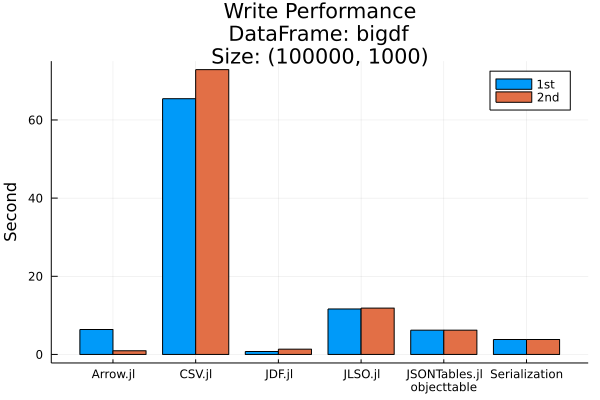

In [47]:
groupedbar(
    # Exclude JSONTables.jl arraytable due to timing
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "JSONTables.jl\nobjecttable"],
            inner = 2),
    [csvwrite1, csvwrite2, serializewrite1, serializewrite1, jdfwrite1, jdfwrite2,
     jlsowrite1, jlsowrite2, arrowwrite1, arrowwrite2, jsontablesowrite2, jsontablesowrite2],
    group = repeat(["1st", "2nd"], outer = 6),
    ylab = "Second",
    title = "Write Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

In [48]:
data_files = ["bigdf1.csv", "bigdf.bin", "bigdf.arrow", "bigdf1.json", "bigdf2.json"]
df = DataFrame(file = data_files, size = getfield.(stat.(data_files), :size))
append!(df, DataFrame(file = "bigdf.jdf", size=reduce((x,y)->x+y.size,
                                                      stat.(joinpath.("bigdf.jdf", readdir("bigdf.jdf"))),
                                                      init=0)))
sort!(df, :size)

6×2 DataFrame
 Row │ file         size       
     │ String       Int64      
─────┼─────────────────────────
   1 │ bigdf.arrow    16152106
   2 │ bigdf.bin      51774521
   3 │ bigdf.jdf     100765595
   4 │ bigdf1.csv    550810955
   5 │ bigdf2.json   550814956
   6 │ bigdf1.json  1240306063

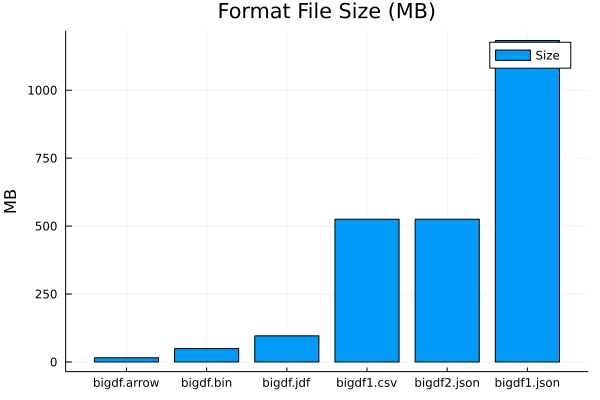

In [49]:
@df df plot(:file, :size/1024^2, seriestype=:bar, title = "Format File Size (MB)", label="Size", ylab="MB")

In [50]:
println("First run")
println("CSV.jl")
csvread1 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread1 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread1 = @elapsed @time JDF.load("bigdf.jdf") |> DataFrame
println("JLSO.jl")
jlsoread1 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread1 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread1copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread1 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread1 = @elapsed @time open(jsontable, "bigdf2.json")
println("Second run")
csvread2 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread2 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread2 = @elapsed @time JDF.load("bigdf.jdf") |> DataFrame
println("JLSO.jl")
jlsoread2 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread2 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread2copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread2 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread2 = @elapsed @time open(jsontable, "bigdf2.json");

First run
CSV.jl
 10.398762 seconds (1.04 M allocations: 375.819 MiB, 6.45% compilation time)
Serialization
  8.351391 seconds (99.32 M allocations: 1.576 GiB, 4.10% gc time, 0.29% compilation time)
JDF.jl
  3.043685 seconds (319.81 k allocations: 375.495 MiB, 6.16% gc time, 37.08% compilation time)
JLSO.jl
  4.636876 seconds (99.42 M allocations: 1.594 GiB, 7.47% gc time, 0.50% compilation time)
Arrow.jl
  0.400513 seconds (460.82 k allocations: 26.664 MiB, 36.75% compilation time)
  1.066083 seconds (103.50 k allocations: 101.364 MiB)
JSONTables.jl arraytable
153.487451 seconds (2.40 M allocations: 12.964 GiB, 2.55% gc time, 0.00% compilation time)
JSONTables.jl objecttable
 12.353227 seconds (55.03 k allocations: 2.797 GiB, 17.09% gc time, 1.45% compilation time)
Second run
  8.284667 seconds (13.69 k allocations: 309.052 MiB)
Serialization
  8.503313 seconds (99.30 M allocations: 1.575 GiB, 3.96% gc time)
JDF.jl
  1.699008 seconds (77.22 k allocations: 363.054 MiB)
JLSO.jl
  5.1023

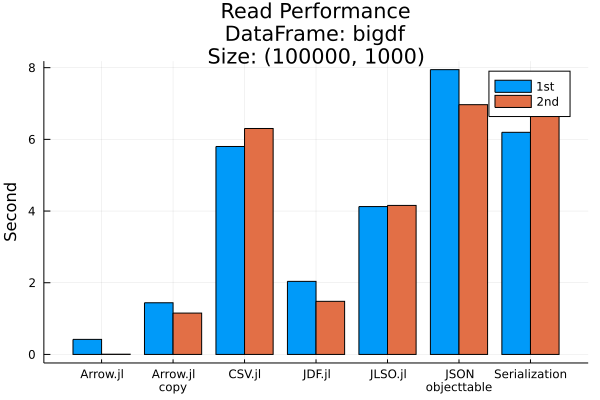

In [59]:
# Exclude JSON\narraytable arraytable due to much longer timing
groupedbar(
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "Arrow.jl\ncopy", #"JSON\narraytable",
            "JSON\nobjecttable"], inner = 2),
    [csvread1, csvread2, serializeread1, serializeread2, jdfread1, jdfread2, jlsoread1, jlsoread2,
     arrowread1, arrowread2, arrowread1+arrowread1copy, arrowread2+arrowread2copy,
     # jsontablesaread1, jsontablesaread2,
     jsontablesoread1, jsontablesoread2],    
    group = repeat(["1st", "2nd"], outer = 7),
    ylab = "Second",
    title = "Read Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

### Using gzip compression

A common user requirement is to be able to load and save CSV that are compressed using gzip.
Below we show how this can be accomplished using CodecZlib.jl.
The same pattern is applicable to JSONTables.jl compression/decompression.

Again make sure that you do not have file named `df_compress_test.csv.gz` in your working directory

We first generate a random data frame

In [44]:
df = DataFrame(rand(1:10, 10, 1000), :auto)

10×1000 DataFrame
 Row │ x1     x2     x3     x4     x5     x6     x7     x8     x9     x10    x ⋯
     │ Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1      6      3      2      9      7      2      1      1      5    ⋯
   2 │     9      1      9      5      4      8      6      9      8      4
   3 │     8      1     10      2      8      5      1      9      8      4
   4 │    10      9      6      6      1      6      6      2      8      1
   5 │     1      6      7      5      7      5      3      6     10      1    ⋯
   6 │     4      9      7     10      8      6      1      3      8      8
   7 │     4      9      3      2      5      5      8      7      9      6
   8 │     7      7      2      4      6      6      2      5      6      8
   9 │     4      6      3      8      2      7      2      6      2      2    ⋯
  10 │     1      7      7      7      6      9      9      1      8      4
                                                             990 columns omitted

In [45]:
# GzipCompressorStream comes from CodecZlib

open("df_compress_test.csv.gz", "w") do io
    stream = GzipCompressorStream(io)
    CSV.write(stream, df)
    close(stream)
end

In [46]:
df2 = CSV.File(transcode(GzipDecompressor, Mmap.mmap("df_compress_test.csv.gz"))) |> DataFrame

10×1000 DataFrame
 Row │ x1     x2     x3     x4     x5     x6     x7     x8     x9     x10    x ⋯
     │ Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     1      6      3      2      9      7      2      1      1      5    ⋯
   2 │     9      1      9      5      4      8      6      9      8      4
   3 │     8      1     10      2      8      5      1      9      8      4
   4 │    10      9      6      6      1      6      6      2      8      1
   5 │     1      6      7      5      7      5      3      6     10      1    ⋯
   6 │     4      9      7     10      8      6      1      3      8      8
   7 │     4      9      3      2      5      5      8      7      9      6
   8 │     7      7      2      4      6      6      2      5      6      8
   9 │     4      6      3      8      2      7      2      6      2      2    ⋯
  10 │     1      7      7      7      6      9      9      1      8      4
                                                             990 columns omitted

In [47]:
df == df2

true

### Using zip files

Sometimes you may have files compressed inside a zip file.

In such a situation you may use [ZipFile.jl](https://github.com/fhs/ZipFile.jl) in conjunction an an appropriate reader to read the files.

Here we first create a ZIP file and then read back its contents into a `DataFrame`.

In [48]:
df1 = DataFrame(rand(1:10, 3, 4), :auto)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     7      6      7      9
   2 │     3      4      1      1
   3 │     8      7      8      3

In [49]:
df2 = DataFrame(rand(1:10, 3, 4), :auto)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     4      7      2      8
   2 │     3      9     10      2
   3 │     4      5      9      3

And we show yet another way to write a `DataFrame` into a CSV file

In [50]:
# write a CSV file into the zip file
w = ZipFile.Writer("x.zip")

f1 = ZipFile.addfile(w, "x1.csv")
write(f1, sprint(show, "text/csv", df1))

# write a second CSV file into zip file
f2 = ZipFile.addfile(w, "x2.csv", method=ZipFile.Deflate)
write(f2, sprint(show, "text/csv", df2))

close(w)

Now we read the CSV we have written:

In [51]:
z = ZipFile.Reader("x.zip");

In [52]:
# find the index index of file called x1.csv
index_xcsv = findfirst(x->x.name == "x1.csv", z.files)
# to read the x1.csv file in the zip file
df1_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     7      6      7      9
   2 │     3      4      1      1
   3 │     8      7      8      3

In [53]:
df1_2 == df1

true

In [54]:
# find the index index of file called x2.csv
index_xcsv = findfirst(x->x.name == "x2.csv", z.files)
# to read the x2.csv file in the zip file
df2_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

3×4 DataFrame
 Row │ x1     x2     x3     x4    
     │ Int64  Int64  Int64  Int64 
─────┼────────────────────────────
   1 │     4      7      2      8
   2 │     3      9     10      2
   3 │     4      5      9      3

In [55]:
df2_2 == df2

true

Note that once you read a given file from `z` object its stream is all used-up (it is at its end). Therefore to read it again you need to close `z` and open it again.

Also do not forget to close the zip file once done.

In [56]:
close(z)

Finally, let's clean up. Do not run the next cell unless you are sure that it will not erase your important files.

In [57]:
foreach(rm, ["x1.csv", "x.bin", "x.jlso", "x1.json", "x2.json",
             "bigdf1.csv", "bigdf.bin", "bigdf.jlso", "bigdf1.json", "bigdf2.json", 
             "x.zip"])

In [58]:
rm("bigdf.jdf", recursive=true)
rm("x.jdf", recursive=true)

Note that we did not remove `x.arrow` and `bigdf.arrow` and `df_compress_test.csv.gz` - you have to do it manually, as these files are memory mapped.